# Step 2

In step 2 you will be using **Pytorch** to import MNIST, train a neural network on MNIST, find examples that "fool" that trained network, and, if you're a 6505 student, propose a way to deal with these examples.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im



In [2]:
#hyperparameters
batch_size = 64
total_epochs = 10
lr = 0.01
epsilons = [0,0.05,0.15,0.25]

## Question 1

Start by importing both the training and testing MNIST datasets using DataLoaders and the torchvision provided datasets. You can set both the training and testing batch size to be whatever you feel is best.

In [3]:
train_data = torchvision.datasets.MNIST(root='./data',
                                        train=True, 
                                        transform=torchvision.transforms.ToTensor(),  
                                        download=True)

train_data,experiment_data = random_split(train_data,[50000,10000])

train_loader = DataLoader(dataset= train_data, batch_size=batch_size, shuffle=True)
experiment_loader = DataLoader(dataset=experiment_data, batch_size=1,shuffle=True)

test_data = torchvision.datasets.MNIST(root='./data',
                                        train=False, 
                                        transform=torchvision.transforms.ToTensor(),  
                                        download=True)
test_loader = DataLoader(dataset=test_data,batch_size = batch_size,shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Question 2

Define a network with the following architecture:

Conv2d (input channels=1, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=15,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=30,kernel_size=5)
        self.dropout1 = nn.Dropout2d(p = 0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(480,64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64,10)
        self.softmax = nn.LogSoftmax()
    
    def forward(self,finput):
        finput = F.relu(self.pool1(self.conv1(finput)))
        #print(finput.shape)
        finput = F.relu(self.pool2(self.dropout1(self.conv2(finput))))
        #print(finput.shape)
        finput = torch.flatten(finput,start_dim=1)
        #print(finput.shape)
        finput = F.relu(self.fc1(finput))
        #print(finput.shape)
        finput = self.fc2(self.dropout2(finput))
        #print(finput.shape)
        finput = self.softmax(finput)
        #print(finput.shape)
        return finput

In [5]:
model = ConvNet()

## Question 3

Train the network you defined in the previous question on MNIST, using the optimizer and the number of training epochs you deem appropriate. Use a cross-entropy loss. Each epoch test your model on the testing dataset and print the value of the accuracy that you achieve. Produce a plot of the loss against the number of epochs.

**Note**: Do not be overly worried about the accuracy that you achieve with your model. It should be upwards of 95% at the very least, but you won't get bonus marks for training a model that has 99.x% accuracy.

In [6]:
loss_criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy after  1  epochs :  71.69
Accuracy after  2  epochs :  89.92999999999999
Accuracy after  3  epochs :  92.85
Accuracy after  4  epochs :  94.36
Accuracy after  5  epochs :  95.03
Accuracy after  6  epochs :  95.44
Accuracy after  7  epochs :  96.04
Accuracy after  8  epochs :  96.38
Accuracy after  9  epochs :  96.41999999999999
Accuracy after  10  epochs :  96.75


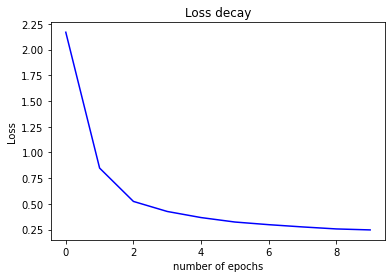

In [7]:
#training loop
loss_values = []
for epoch in range(total_epochs):
    running_loss = 0
    model.train()
    for images,labels in train_loader:
        #forward pass
        outputs = model(images)
        #finding loss
        loss = loss_criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_values.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        model.eval()
        correct_samples = 0
        total_samples = 0
        for images,labels in test_loader:
            pred_ratio = model(images)
            _, pred_labels = torch.max(pred_ratio,1)
            total_samples += labels.size(0)
            correct_samples += (pred_labels==labels).sum().item()
        accuracy = (correct_samples/total_samples)*100
        print('Accuracy after ',epoch+1,' epochs : ', accuracy)

plt.plot(range(total_epochs),loss_values,'blue')
plt.title('Loss decay')
plt.xlabel('number of epochs')
plt.ylabel('Loss')
plt.show()

In [8]:
torch.save(model.state_dict(), 'model_orignal')

## Question 4

### Part 1

Suppose that you have a fully trained network, and that you wanted to find images that "fooled" it, i.e., images that are misclassified by your network.

One simple approach would be to take an input image, and then alter it in the direction of ascent of the gradient of the loss w.r.t to the pixels of that input image. Mathematically:

$
\begin{equation}
x^´ = x + \epsilon \,\text{sign}\left[\nabla_x \mathcal{L(\theta,x,y}) \right]
\end{equation}
$,

where $x^´$ is the (perturbed) image you hope will fool the classifier, $x$ is the input image, $y$ is the label of the original image, $\theta$ are the network parameters, $\epsilon$ is a hyperparameter controlling the strength of the perturbation, and $\mathcal{L}$ is the loss.

Implement this in Pytorch, using the model you trained in question 3. Generate one $x'$ for all the images in the MNIST testing set, keep the $x^´$ that sucessfully fool your model, alongside their original labels and their predicted (wrong) labels, and print out the accuracy of your model in the perturbed testing set (all the $x^´$ obtained from the images in the original testing set using the equation above), for the following epsilons: $\epsilon = 0,0.05,0.15,0.25$

**Hint**: A line of code similar to "data.requires_grad = True" is needed somewhere in your solution

### Part 2

Show some of the images that fooled your network in part 1 (plt.imshow will come in handy), making sure to include both what their original and perturbed labels were in the title of your plot. Does it make sense to you that these images are fooling your network? Why or why not?

In [9]:
exp_itr = iter(experiment_loader)
images,labels = exp_itr.next()
exp_images,exp_labels = images.numpy(),labels.numpy()


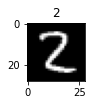

In [10]:
f = plt.figure()
for image,i,label in zip(exp_images[0:5],range(5),exp_labels[0:5]):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(np.reshape(image, (28, 28)),cmap="gray")
    plt.title(label)
plt.show(block=True)

In [11]:
def apply_fgsm(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [12]:
def get_adversarial_images(perturb_model,test_model,experiment_loader,epsilon,IsFeatureModel):
    correct = 0
    adv_examples =[]

    for image, label in experiment_loader:
        perturb_model.train()
        image.requires_grad = True
        out = perturb_model(image)
        _,pred_labels = torch.max(out,1)

        if pred_labels.item() != label.item():
            continue
        
        loss = loss_criterion(out,label)
        perturb_model.zero_grad()
        loss.backward()

        image_grad = image.grad.data
        perturbed_data = apply_fgsm(image,epsilon,image_grad)

        #again classify perturbed images
        if(IsFeatureModel == True):
            model.load_state_dict(torch.load('model_new'))
        test_model.eval()
        perturbed_out = test_model(perturbed_data)
        _,perturbed_predictions = torch.max(perturbed_out,1)

        if perturbed_predictions.item() == label.item():
            correct+=1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (pred_labels.item(), perturbed_predictions.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (pred_labels.item(), perturbed_predictions.item(), adv_ex) )

    accuracy = correct/float(len(experiment_loader))
    print("Epsilon: {}\t Experiment data Accuracy = {} / {} = {}".format(epsilon, correct, len(experiment_loader), accuracy))
    
    return adv_examples

In [13]:
fooled_examples = []
for eps in epsilons:
    ex = get_adversarial_images(model,model,experiment_loader, eps,False)
    fooled_examples.append(ex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	 Experiment data Accuracy = 9238 / 10000 = 0.9238
Epsilon: 0.05	 Experiment data Accuracy = 8940 / 10000 = 0.894
Epsilon: 0.15	 Experiment data Accuracy = 7128 / 10000 = 0.7128
Epsilon: 0.25	 Experiment data Accuracy = 3504 / 10000 = 0.3504


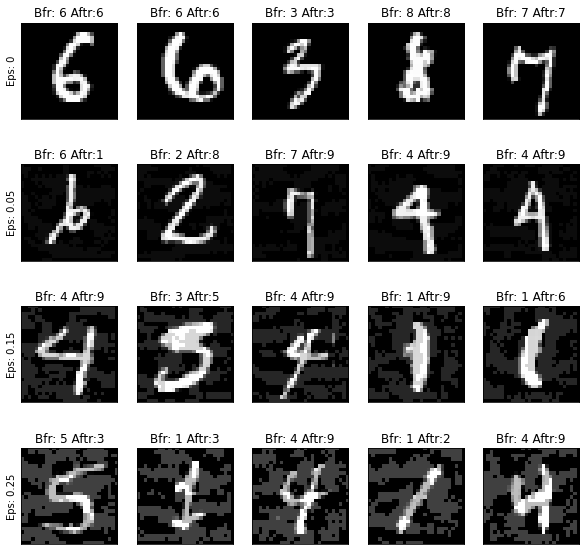

In [14]:
counter = 0
plt.figure(figsize=(10,10))
for x in range(len(epsilons)):
    for y in range(len(fooled_examples[i])):
        counter += 1
        plt.subplot(len(epsilons),len(fooled_examples[0]),counter)
        plt.xticks([], [])
        plt.yticks([], [])
        if y == 0:
            plt.ylabel("Eps: {}".format(epsilons[x]))
        orig_pred,adv_pred,image = fooled_examples[x][y]
        plt.title("Bfr: {} Aftr:{}".format(orig_pred, adv_pred))
        plt.imshow(image, cmap="gray")
plt.show()

**Yes, perturbed images that we got after performing fast gradient sign method fooled our network. This is because we added noise to our data, FGSM is used to add noise in direction same as the gradient of cost function with respect to data. And this noise is scaled by epsilon i.e more the epsilon value more the noise is added to our images and more it get difficult for our model to predict correct classes.**

## Question 5 (6505 only)

Can you think of a way to make your network more robust to these perturbed images? Does your proposal have drawbacks? Run any experiments you feel are needed to prove your claims.

**Note**: You are not expected to find a perfect solution, just something that makes sense and has some evidence backing it up. You will be marked on the persuasiveness of your argument/experiments and how much sense your proposal makes, not the overall improvements in robustness you achieve (however, if your proposal worsens the problem, then that's a pretty solid hint you're going in the wrong direction).

## Experiment -1 With Batchnorm

First experiment that we tried is including batchnorm layer in our model, because as we have added noise to our dataset and to rectify these noisy values we thought of adding batchnorm layer will help our model while classifying adversiral images. 

And, results showed that it does help for the greater epsilon values in which we added alot of noise. As we can see from results that for epsilon .15 and .25 our model with batchnorm did performed better than model without batchnorm layer.

In [15]:
class ConvNet_withBatchNorm(nn.Module):
    def __init__(self):
        super(ConvNet_withBatchNorm,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=15,kernel_size=5)
        self.Bnorm1 = nn.BatchNorm2d(15)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=30,kernel_size=5)
        self.Bnorm2 = nn.BatchNorm2d(30)
        self.dropout1 = nn.Dropout2d(p = 0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(480,64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64,10)
        self.softmax = nn.LogSoftmax()
    
    def forward(self,finput):
        finput = F.relu(self.Bnorm1(self.pool1(self.conv1(finput))))
        #print(finput.shape)
        finput = F.relu(self.Bnorm2(self.dropout1(self.pool2(self.conv2(finput)))))
        #print(finput.shape)
        finput = torch.flatten(finput,start_dim=1)
        #print(finput.shape)
        finput = F.relu(self.fc1(finput))
        #print(finput.shape)
        finput = self.fc2(self.dropout2(finput))
        #print(finput.shape)
        finput = self.softmax(finput)
        #print(finput.shape)
        return finput

In [16]:
model_withBnorm = ConvNet_withBatchNorm()
optimizer = torch.optim.SGD(model_withBnorm.parameters(), lr = lr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Model with BatchNorm Accuracy after  1  epochs :  85.79
Model with BatchNorm Accuracy after  2  epochs :  91.78
Model with BatchNorm Accuracy after  3  epochs :  93.39
Model with BatchNorm Accuracy after  4  epochs :  94.58
Model with BatchNorm Accuracy after  5  epochs :  95.09
Model with BatchNorm Accuracy after  6  epochs :  95.77
Model with BatchNorm Accuracy after  7  epochs :  96.02000000000001
Model with BatchNorm Accuracy after  8  epochs :  96.0
Model with BatchNorm Accuracy after  9  epochs :  96.32
Model with BatchNorm Accuracy after  10  epochs :  96.27


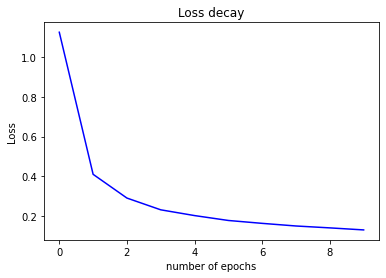

In [17]:
#training loop
loss_values = []
for epoch in range(total_epochs):
    running_loss = 0
    for images,labels in train_loader:
        model.train()
        #forward pass
        outputs = model_withBnorm(images)
        #finding loss
        loss = loss_criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_values.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        model.eval()
        correct_samples = 0
        total_samples = 0
        for images,labels in test_loader:
            pred_ratio = model_withBnorm(images)
            _, pred_labels = torch.max(pred_ratio,1)
            total_samples += labels.size(0)
            correct_samples += (pred_labels==labels).sum().item()
        accuracy = (correct_samples/total_samples)*100
        print('Model with BatchNorm Accuracy after ',epoch+1,' epochs : ', accuracy)

plt.plot(range(total_epochs),loss_values,'blue')
plt.title('Loss decay')
plt.xlabel('number of epochs')
plt.ylabel('Loss')
plt.show()

In [18]:
torch.save(model_withBnorm.state_dict(), 'model_withBatchnorm')

**Below shows result for adversarial attack on simple model created in step 2:**



In [19]:
fooled_examples = []
for eps in epsilons:
    ex = get_adversarial_images(model,model, experiment_loader, eps,False)
    fooled_examples.append(ex)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	 Experiment data Accuracy = 9237 / 10000 = 0.9237
Epsilon: 0.05	 Experiment data Accuracy = 8971 / 10000 = 0.8971
Epsilon: 0.15	 Experiment data Accuracy = 7142 / 10000 = 0.7142
Epsilon: 0.25	 Experiment data Accuracy = 3484 / 10000 = 0.3484


**Below shows result for adversarial attack on model with Batch norm layers added:**

In [20]:
fooled_examples = []
for eps in epsilons:
    ex = get_adversarial_images(model,model_withBnorm, experiment_loader, eps,False)
    fooled_examples.append(ex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	 Experiment data Accuracy = 9243 / 10000 = 0.9243
Epsilon: 0.05	 Experiment data Accuracy = 9237 / 10000 = 0.9237
Epsilon: 0.15	 Experiment data Accuracy = 8809 / 10000 = 0.8809
Epsilon: 0.25	 Experiment data Accuracy = 6525 / 10000 = 0.6525


## Experiment 2 - Using Feature Maps


In this experiment, what we tried is after training model in step 2 we extracted layers from that model and passed all our training set on that trained Conv-1 layer to generate feature maps. 

Those generated featured maps we again trained in already trained model to make our model more generalize. As feature maps are already noisy images so traing model on feature maps might help harnessing adverseral attack.

Results showed us that, In smaller epsilon values it didnot increased accuaracy but neither worsen it. But in epsilon : 0.25 we can see our accuaracy actually increased for the pre-trained model that we trained on feature maps. 

hence this showed us that training model on fetaure maps added more generaliztion to our model and can help us a little to overcome adversarial attacks

In [21]:
class ConvNet_new(nn.Module):
    def __init__(self):
        super(ConvNet_new,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=15,kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=30,kernel_size=5)
        self.dropout1 = nn.Dropout2d(p = 0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(480,64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64,10)
        self.softmax = nn.LogSoftmax()
    
    def forward(self,finput):
        finput = F.relu(self.pool1(self.conv1(finput)))
        #print(finput.shape)
        finput = F.relu(self.pool2(self.dropout1(self.conv2(finput))))
        #print(finput.shape)
        finput = torch.flatten(finput,start_dim=1)
        #print(finput.shape)
        finput = F.relu(self.fc1(finput))
        #print(finput.shape)
        finput = self.fc2(self.dropout2(finput))
        #print(finput.shape)
        finput = self.softmax(finput)
        #print(finput.shape)
        return finput

In [22]:
model_new = ConvNet_new() 
model_new.load_state_dict(torch.load('model_orignal'))

<All keys matched successfully>

In [23]:
def extract_featuremaps(batch_images):
    model_weights =[]
    conv_layers = []
    model_children = list(model.children())
    counter = 0
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter+=1
                        model_weights.append(child.weight)
                        conv_layers.append(child)

    outputs = []
    names = []
    for layer in conv_layers[0:1]:
        image = layer(batch_images)
        outputs.append(image)
        names.append(str(layer))

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(1)
        gray_scale = torch.sum(feature_map,1)
        gray_scale = gray_scale / feature_map.shape[1]
        processed.append(gray_scale.data.cpu())

    feature_map_image = []
    for i in range(len(processed)):
        feature_map_image = processed[i]

    return feature_map_image

In [24]:
def getfeatures_from_loader(input_loader):
   train_feature_maps = [] 
   train_labels = []
   for images,labels in input_loader:
      train_labels.append(labels)
      train_feature_maps.append(extract_featuremaps(images))
   feature_list = []
   for i in train_feature_maps:
      feature_list.append(torch.tensor(i.reshape(i.shape[0],1,24,24)))
   return np.array(feature_list), train_labels

In [25]:
train_featuremaps, feature_train_labels = getfeatures_from_loader(train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

In [26]:
optimizer = torch.optim.SGD(model_new.parameters(), lr = lr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy after  1  epochs :  95.6
Accuracy after  2  epochs :  95.41
Accuracy after  3  epochs :  95.27
Accuracy after  4  epochs :  95.53
Accuracy after  5  epochs :  95.38
Accuracy after  6  epochs :  95.6
Accuracy after  7  epochs :  95.67999999999999
Accuracy after  8  epochs :  95.66
Accuracy after  9  epochs :  95.45
Accuracy after  10  epochs :  95.56
Accuracy after  11  epochs :  95.54
Accuracy after  12  epochs :  95.74000000000001
Accuracy after  13  epochs :  95.56
Accuracy after  14  epochs :  95.81
Accuracy after  15  epochs :  95.78
Accuracy after  16  epochs :  95.78
Accuracy after  17  epochs :  95.81
Accuracy after  18  epochs :  95.77
Accuracy after  19  epochs :  95.93
Accuracy after  20  epochs :  96.00999999999999


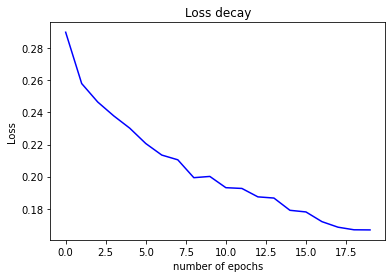

In [27]:

#training loop
loss_values = []
for epoch in range(total_epochs+10):
    running_loss = 0
    for images,labels in zip(train_featuremaps, feature_train_labels):
        model_new.train()
        #forward pass
        outputs = model_new(images)
        #finding loss
        loss = loss_criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_values.append(running_loss/len(feature_train_labels))
    with torch.no_grad():
        model.load_state_dict(model_new.state_dict())
        model.eval()
        correct_samples = 0
        total_samples = 0
        for images,labels in test_loader:
            pred_ratio = model(images)
            _, pred_labels = torch.max(pred_ratio,1)
            total_samples += labels.size(0)
            correct_samples += (pred_labels==labels).sum().item()
        accuracy = (correct_samples/total_samples)*100
        print('Accuracy after ',epoch+1,' epochs : ', accuracy)
plt.plot(range(total_epochs+10),loss_values,'blue')
plt.title('Loss decay')
plt.xlabel('number of epochs')
plt.ylabel('Loss')
plt.show()

In [28]:
torch.save(model_new.state_dict(), 'model_new')

In [29]:
model.load_state_dict(torch.load('model_orignal'))

print("Testing adversiral attack on simple model created in step-2:")
fooled_examples = []
for eps in epsilons:
    ex = get_adversarial_images(model,model,experiment_loader, eps,False)
    fooled_examples.append(ex)

print("Testing adversiral attack on model trained with feature maps:")
fooled_examples = []
for eps in epsilons:
    ex = get_adversarial_images(model,model,experiment_loader, eps,True)
    fooled_examples.append(ex)

Testing adversiral attack on simple model created in step-2:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	 Experiment data Accuracy = 9218 / 10000 = 0.9218
Epsilon: 0.05	 Experiment data Accuracy = 8953 / 10000 = 0.8953
Epsilon: 0.15	 Experiment data Accuracy = 7116 / 10000 = 0.7116
Epsilon: 0.25	 Experiment data Accuracy = 3527 / 10000 = 0.3527
Testing adversiral attack on model trained with feature maps:
Epsilon: 0	 Experiment data Accuracy = 9072 / 10000 = 0.9072
Epsilon: 0.05	 Experiment data Accuracy = 8758 / 10000 = 0.8758
Epsilon: 0.15	 Experiment data Accuracy = 6678 / 10000 = 0.6678
Epsilon: 0.25	 Experiment data Accuracy = 3879 / 10000 = 0.3879
